# Instructions for getting dataframe from RDS

```
get_batch_data(
    base_coin='ETH',
    quote_coin='BTC',
    start_time='2021-01-01',                  #YYYY-MM-DD
    end_time='2021-07-01',                    #YYYY-MM-DD
    columns=['close','close_30','close_100'], # any valid features with `_x` suffix support
    batch_size=1000000,                       # Large number to get everything
    extra_rows=10,                            # Fetch extra rows for custom feature engineering
    use_cache=False,                          # Cache can be used when current time > end_time
)

VALID_FEATURES = [
    'pair_id','open_time','close_time','dow','tod',
    'open','high','low','close',
    'number_of_trades','volume','quote_asset_volume','taker_buy_base_asset_volume','taker_buy_quote_asset_volume',
    'ma14','ma30','ma90',
    'sup14','sup30','sup90',
    'res14','res30','res90',
    'atr','atr_diff','atr_ma14',
    'rsi','rsi_diff','rsi_ma14',
    'trend_up','trend_up3','trend_up14','trend_up30',
    'cs_ss','cs_ssr','cs_hm','cs_hmr','cs_brh','cs_buh','cs_ebu','cs_ebr'
]
```

# Instructions for Manual Simulation

1. Decide on a name for your model.  Add first letter of your name and numbers as prefix  For example: `t0_dummy`.
2. Create a `.py` file with the name of your model in the `trade_models` directory (`./trade_models/t0_dummy.py`)
3. Import your model in `./trade_models/__init__.py` by adding `from . import t0_dummy`
4. Place any pre-trained models or scalers into the `./trade_models/assets/` directory with your model name as prefix.
5. Configure portfolio in the following cells.
    1. For `max_batch_size`, it is purely for memory considerations.  It does an SQL query per batch, so don't make it too small.
    2. Parameters inside portfolios are accessible inside the trade models
6. Run all

Sample portfolio (all fields must exist)
```
    {
        # Common parameters
        'portfolio_name' : f'ETH <-> BTC t0_dummy no fees',
        'trade_model' : 't0_dummy',      # name of the model to use
        'starting_coin' : 'ETH',         # aka the "base" coin
        'pair_coin' : 'BTC',             # aka the "quote" coin
        'max_batch_size' : 10000,        # how many entries to process per batch
        'starting_funds' : 16,           # amount of funds for starting coin
        'trading_fees_percent' : 0.1,    # trading fees in percent (0.1%)
        'trading_fees_buy' : 0.005,      # (0.005 ETH transaction fee to buy BTC)
        'trading_fees_sell' : 0.0004,    # (0.0004 BTC transaction fee to sell back to ETC)

        # Optional model specific parameteres
        'parameter_sample' : 'test',     # these variables are accessible in your model
    }
```

In [1]:
from itertools import permutations
import numpy as np

start_simulation = '2021-01-01' #YYYY-MM-DD
end_simulation = '2021-07-01' #YYYY-MM-DD

portfolios = []

for a,b in permutations(['ETH','BTC'],2):
    for x in np.linspace(0.1, 0.3, num=3):
        for y in np.linspace(0.7, 0.9, num=3):
            portfolios.append({
                'portfolio_name' : f'TC2_NN_{a}{b}_{x}_{y}',
                'trade_model' : 't2_nn',
                'starting_coin' : a,
                'pair_coin' : b,
                'max_batch_size' : 10000,
                'extra_rows' : 0,
                'starting_funds' : 1,
                'trading_fees_percent' : 0.1,
                'trading_fees_buy' : 0,
                'trading_fees_sell' : 0,
                'model_filepath': 'trade_models/assets/t4_nn.pth',
                'model_bs_ratio': (x,y)
            }
        )

'''
portfolios = [
    {
        'portfolio_name' : f'TC2_NN_EB_test',
        'trade_model' : 't4_nn',
        'starting_coin' : 'ETH',
        'pair_coin' : 'BTC',
        'max_batch_size' : 10000,
        'extra_rows' : 0,
        'starting_funds' : 1,
        'trading_fees_percent' : 0.1,
        'trading_fees_buy' : 0,
        'trading_fees_sell' : 0,
        'model_filepath': 'trade_models/assets/t2_nn.pth',
        'model_bs_ratio': (-0.5,0.1)
    },
]'''

"\nportfolios = [\n    {\n        'portfolio_name' : f'TC2_NN_EB_test',\n        'trade_model' : 't4_nn',\n        'starting_coin' : 'ETH',\n        'pair_coin' : 'BTC',\n        'max_batch_size' : 10000,\n        'extra_rows' : 0,\n        'starting_funds' : 1,\n        'trading_fees_percent' : 0.1,\n        'trading_fees_buy' : 0,\n        'trading_fees_sell' : 0,\n        'model_filepath': 'trade_models/assets/t2_nn.pth',\n        'model_bs_ratio': (-0.5,0.1)\n    },\n]"

# STOP

You shouldn't need to modify anything below this cell

# CODE FOR SIMULATION STARTS

In [2]:
import psycopg2
import pandas as pd
import numpy as np
import re
from datetime import datetime
import pytz
import re
from operator import itemgetter

# models
import trade_models
from trade_models import *


VALID_FEATURES = [
    'pair_id','open_time','close_time','dow','tod',
    'open','high','low','close',
    'number_of_trades','volume','quote_asset_volume','taker_buy_base_asset_volume','taker_buy_quote_asset_volume',
    'ma14','ma30','ma90',
    'sup14','sup30','sup90',
    'res14','res30','res90',
    'atr','atr_diff','atr_ma14',
    'rsi','rsi_diff','rsi_ma14',
    'trend_up','trend_up3','trend_up14','trend_up30',
    'cs_ss','cs_ssr','cs_hm','cs_hmr','cs_brh','cs_buh','cs_ebu','cs_ebr'
]

In [3]:
# local postgres connection only
import hidden
sql_string = hidden.psycopg2(hidden.secrets())
print('PostgreSQL connection data taken from hidden.py')

# Make the connection and cursor
conn = psycopg2.connect(sql_string, connect_timeout=3)

PostgreSQL connection data taken from hidden.py


In [4]:
# validate inputs and portfolio parameters

def validate(date_text):
    try:
        datetime.strptime(date_text, '%Y-%m-%d')
    except ValueError:
        raise ValueError("Incorrect data format, should be YYYY-MM-DD")
        
# validate start / end string format input to protect against injection
validate(start_simulation)
validate(end_simulation)

for p in portfolios:
    # validate symbol
    assert re.match('^[A-Z]{2,}$', p['starting_coin']), f"{p['starting_coin']} is invalid starting coin"
    assert re.match('^[A-Z]{2,}$', p['pair_coin']), f"{p['pair_coin']} is invalid pair coin"

    # validate starting funds
    assert p['starting_funds'] > 0, "Starting funds for must be > 0"

    # validate fees
    assert p['trading_fees_percent'] >= 0, "Trading Fees % for must be >= 0%"
    assert p['trading_fees_percent'] < 100, "Trading Fees % for must be < 100%"
    assert p['trading_fees_buy'] >= 0, "Trading Fees (buy) for must be >= 0"
    assert p['trading_fees_sell'] >= 0, "Trading Fees (sell) for must be >= 0"

    # validate batch size
    assert (isinstance(p['max_batch_size'], int) and p['max_batch_size'] > 0), f"{p['max_batch_size']} is not a valid batch size"

    # maybe we should validate model names too!
    # TODO: validate model names

In [5]:
# These are only used for caching
import hashlib
import pickle

def get_batch_data(base_coin, quote_coin, start_time, end_time, columns, batch_size=10000, extra_rows=0, use_cache=True):
    column_info = [(x,) + re.match('^(?P<feature>[a-z][a-z0-9]*(?:_[a-z][a-z0-9]*)*)(?:_(?P<shift>[0-9]{1,3}))?$',x).groups() for x in columns]
    max_lookback = max([(0 if x==None else int(x)) for _,_,x in column_info])
    s = base_coin+quote_coin+f"{start_time}"+f"{end_time}"+"".join(columns)+str(batch_size)+str(extra_rows)
    h = hashlib.md5(s.encode('utf-8')).hexdigest()
    should_use_cache = use_cache and (datetime.strptime(end_time, '%Y-%m-%d') < datetime.now(pytz.timezone('UTC')).replace(tzinfo=None))
    if should_use_cache:
        # Can use cache
        try:
            with open(f'./cache_data/{h}.pkl', 'rb') as fp:
                print(f"Using cache file: ./cache_data/{h}.pkl")
                return pickle.load(fp)
        except:
            print(f"No cache found")
            pass

    sql = f"""
select
    f.*, open_time, open, high, low, close, volume, close_time, quote_asset_volume, number_of_trades, taker_buy_base_asset_volume, taker_buy_quote_asset_volume	
from
    (
        (select * from (select id as the_pair from pairs p where p.coin1='{base_coin}' and p.coin2='{quote_coin}') z inner join candlestick_15m on the_pair=pair_id where close_time notnull and open_time < '{start_time}' order by open_time desc limit {max_lookback + extra_rows})
            union all
        (select * from (select id as the_pair from pairs p where p.coin1='{base_coin}' and p.coin2='{quote_coin}') z inner join candlestick_15m on the_pair=pair_id where close_time notnull and open_time between '{start_time}' and '{end_time}' order by open_time limit {batch_size})
    ) cm
inner join 
    features f on f.pair_id = cm.pair_id and f.candle_open_time = cm.open_time
order by
    open_time desc
"""
    base_df = pd.read_sql_query(sql, conn)
    df = base_df[['candle_open_time']].copy()
    for name, feature, shift in column_info:
        assert feature in VALID_FEATURES, f"Invalid feature: {feature} for {name}"
        df[name] = base_df[feature].shift((0 if shift==None else -int(shift)))
        
    if extra_rows == 0:
        extra_df = None
    else:
        extra_df = df.copy()
        extra_df['is_extra'] = ~extra_df['candle_open_time'].between(start_time, end_time)
        extra_df = extra_df.set_index('candle_open_time').sort_index()
        
    df = df[df['candle_open_time'].between(start_time, end_time)]
    df = df.set_index('candle_open_time').sort_index()

    ref_df = base_df[['open_time','open', 'high', 'low', 'close']].copy()
    ref_df = ref_df[ref_df['open_time'].between(start_time, end_time)]
    ref_df = ref_df.set_index('open_time').sort_index()

    batch_close_time = base_df['close_time'].max()
    
    if should_use_cache:
        with open(f'./cache_data/{h}.pkl', 'wb') as fp:
            print(f"Saving cache to: ./cache_data/{h}.pkl")
            pickle.dump((df, ref_df, extra_df, batch_close_time), fp, protocol=4)

    return df, ref_df, extra_df, batch_close_time

In [6]:
def simulate_portfolio(start_time, end_time, portfolio):
    portfolio_name = portfolio['portfolio_name']
    trade_model = portfolio['trade_model']
    starting_coin = portfolio['starting_coin']
    pair_coin = portfolio['pair_coin']
    max_batch_size = portfolio['max_batch_size']
    extra_rows = portfolio['extra_rows']
    starting_funds = portfolio['starting_funds']
    fee_multiplier = 1.0 - portfolio['trading_fees_percent'] / 100
    trading_fees_buy = portfolio['trading_fees_buy']
    trading_fees_sell = portfolio['trading_fees_sell']
    
    model = trade_models.__dict__[trade_model]
    columns = model.columns(portfolio)

    current_time = start_time
    all_output = []
    
    info_dict = portfolio

    while True:
        print("next batch: ", current_time, end=": ")
        batch_data, ref_data, extra_data, batch_close_time = get_batch_data(starting_coin, pair_coin, current_time, end_time, columns, max_batch_size, extra_rows, True)
        if len(batch_data) == 0:
            break

        # Replace any boolean or object columns as int
        for col in batch_data.columns:
            if batch_data[col].dtype.kind in ['b','O']:
                batch_data[col] = batch_data[col].astype(int)
            
        batch_model_decision, batch_execute_price = model.make_decision(batch_data[columns], extra_data, info_dict)

        ref_data['trade_model_decision'] = batch_model_decision.values
        
        ref_data['execute_price'] = batch_execute_price.values

        all_output.append(ref_data)
        current_time = batch_close_time

    results = pd.concat(all_output)
    
    results[['actual_action','fund1','fund2']] = np.nan
    cur_funds = [starting_funds,0]
    results.iloc[0, results.columns.get_loc('fund1')] = starting_funds
    results.iloc[0, results.columns.get_loc('fund2')] = 0

    print("...Simulating actions...")
    
    for x,r in results.iterrows():
        if cur_funds[0] > 0 and cur_funds[1] == 0:
            if r['trade_model_decision'] > 0:
                cur_funds[1] = ((cur_funds[0]-trading_fees_buy) * r['execute_price']) * fee_multiplier
                cur_funds[0] = 0
                results.loc[x,'fund1'] = cur_funds[0]
                results.loc[x,'fund2'] = cur_funds[1]
                results.loc[x,'actual_action'] = 'buy'
        elif cur_funds[1] > 0 and cur_funds[0] == 0:
            if r['trade_model_decision'] < 0:
                cur_funds[0] = ((cur_funds[1]-trading_fees_sell) / r['execute_price']) * fee_multiplier
                cur_funds[1] = 0
                results.loc[x,'fund1'] = cur_funds[0]
                results.loc[x,'fund2'] = cur_funds[1]
                results.loc[x,'actual_action'] = 'sell'
        else:
            # you have run out of money!
            pass
    results[['fund1','fund2']] = results[['fund1','fund2']].ffill()
    results['total_value'] = results['fund1'] + results['fund2'] / results['close']
    results['actual_action'] = results['actual_action'].fillna('none')
    return portfolio_name, results

# START OF SIMULATION

In [7]:
simulation_results = {}

for p in portfolios:
    print(f"\"{p['portfolio_name']}\"")
    %time name, res = simulate_portfolio(start_simulation, end_simulation, p)
    simulation_results[name] = res
    print(f"Final value: {res.iloc[-1,-1]}\n\n")

"TC2_NN_ETHBTC_0.1_0.7"
next batch:  2021-01-01: Using cache file: ./cache_data/6e8ee8f6c0763eb235b7c24134e268de.pkl
next batch:  2021-04-15 06:44:59.999000: Using cache file: ./cache_data/7df139c60ba9dfd52fe6b57589a285aa.pkl
next batch:  2021-07-01 00:14:59: Using cache file: ./cache_data/b247dc6ebb9e841c46e0531801d85bd6.pkl
...Simulating actions...
CPU times: user 4.65 s, sys: 865 ms, total: 5.52 s
Wall time: 5.72 s
Final value: 0.39315283896990383


"TC2_NN_ETHBTC_0.1_0.8"
next batch:  2021-01-01: Using cache file: ./cache_data/6e8ee8f6c0763eb235b7c24134e268de.pkl
next batch:  2021-04-15 06:44:59.999000: Using cache file: ./cache_data/7df139c60ba9dfd52fe6b57589a285aa.pkl
next batch:  2021-07-01 00:14:59: Using cache file: ./cache_data/b247dc6ebb9e841c46e0531801d85bd6.pkl
...Simulating actions...
CPU times: user 5.17 s, sys: 853 ms, total: 6.02 s
Wall time: 7.08 s
Final value: 0.3897587806391561


"TC2_NN_ETHBTC_0.1_0.9"
next batch:  2021-01-01: Using cache file: ./cache_data/6e8ee8f

# END OF SIMULATION

In [8]:
for (k,v),p in zip(simulation_results.items(),portfolios):
    print(k)
    print(f"Portfolio simulation for {p['starting_funds']} {p['starting_coin']} trading against {p['pair_coin']}")
    display(v[v['actual_action']!='none'].rename(columns={'fund1':f"{p['starting_coin']} holding",'fund2':f"{p['pair_coin']} holding",'total_value':f'{p["starting_coin"]} value after trade'}))
    display(v['actual_action'].value_counts())

TC2_NN_ETHBTC_0.1_0.7
Portfolio simulation for 1 ETH trading against BTC


,open,high,low,close,trade_model_decision,execute_price,actual_action,ETH holding,BTC holding,ETH value after trade
open_time,,,,,,,,,,
2021-01-01 00:15:00,0.02543,0.025433,0.025325,0.025368,0.274777,0.025368,buy,0.0,0.025343,0.999


none    17337
buy         1
Name: actual_action, dtype: int64

TC2_NN_ETHBTC_0.1_0.8
Portfolio simulation for 1 ETH trading against BTC


,open,high,low,close,trade_model_decision,execute_price,actual_action,ETH holding,BTC holding,ETH value after trade
open_time,,,,,,,,,,
2021-01-01 08:15:00,0.025282,0.025299,0.0251,0.025149,0.37822,0.025149,buy,0.0,0.025124,0.999


none    17337
buy         1
Name: actual_action, dtype: int64

TC2_NN_ETHBTC_0.1_0.9
Portfolio simulation for 1 ETH trading against BTC


,open,high,low,close,trade_model_decision,execute_price,actual_action,ETH holding,BTC holding,ETH value after trade
open_time,,,,,,,,,,
2021-01-01 22:30:00,0.024991,0.024991,0.024867,0.024867,0.431576,0.024867,buy,0.0,0.024842,0.999


none    17337
buy         1
Name: actual_action, dtype: int64

TC2_NN_ETHBTC_0.2_0.7
Portfolio simulation for 1 ETH trading against BTC


,open,high,low,close,trade_model_decision,execute_price,actual_action,ETH holding,BTC holding,ETH value after trade
open_time,,,,,,,,,,
2021-01-01 00:15:00,0.025430,0.025433,0.025325,0.025368,0.274777,0.025368,buy,0.000000,0.025343,0.999000
2021-01-01 01:30:00,0.025258,0.025492,0.025246,0.025482,-0.386464,0.025482,sell,0.993536,0.000000,0.993536
2021-01-01 01:45:00,0.025493,0.025526,0.025388,0.025441,0.263158,0.025441,buy,0.000000,0.025251,0.992543
2021-01-01 05:00:00,0.025406,0.025496,0.025399,0.025495,-0.347340,0.025495,sell,0.989450,0.000000,0.989450
2021-01-01 05:15:00,0.025496,0.025498,0.025399,0.025420,0.298392,0.025420,buy,0.000000,0.025127,0.988461
...,...,...,...,...,...,...,...,...,...,...
2021-06-30 19:00:00,0.063600,0.063749,0.063312,0.063364,0.368160,0.063364,buy,0.000000,0.002992,0.047224
2021-06-30 19:30:00,0.063743,0.064283,0.063711,0.064239,-0.354392,0.064239,sell,0.046534,0.000000,0.046534
2021-06-30 22:00:00,0.065049,0.065080,0.064526,0.064651,0.382651,0.064651,buy,0.000000,0.003005,0.046488


none    14595
buy      1372
sell     1371
Name: actual_action, dtype: int64

TC2_NN_ETHBTC_0.2_0.8
Portfolio simulation for 1 ETH trading against BTC


,open,high,low,close,trade_model_decision,execute_price,actual_action,ETH holding,BTC holding,ETH value after trade
open_time,,,,,,,,,,
2021-01-01 08:15:00,0.025282,0.025299,0.025100,0.025149,0.378220,0.025149,buy,0.000000,0.025124,0.999000
2021-01-01 13:15:00,0.025060,0.025126,0.025055,0.025109,-0.319364,0.025109,sell,0.999591,0.000000,0.999591
2021-01-01 15:00:00,0.025166,0.025196,0.025105,0.025112,0.337346,0.025112,buy,0.000000,0.025077,0.998591
2021-01-01 15:15:00,0.025114,0.025253,0.025110,0.025243,-0.386464,0.025243,sell,0.992416,0.000000,0.992416
2021-01-01 18:30:00,0.025050,0.025050,0.024953,0.024955,0.358692,0.024955,buy,0.000000,0.024741,0.991423
...,...,...,...,...,...,...,...,...,...,...
2021-06-30 19:00:00,0.063600,0.063749,0.063312,0.063364,0.368160,0.063364,buy,0.000000,0.004952,0.078157
2021-06-30 19:30:00,0.063743,0.064283,0.063711,0.064239,-0.354392,0.064239,sell,0.077016,0.000000,0.077016
2021-06-30 22:00:00,0.065049,0.065080,0.064526,0.064651,0.382651,0.064651,buy,0.000000,0.004974,0.076939


none    15113
buy      1113
sell     1112
Name: actual_action, dtype: int64

TC2_NN_ETHBTC_0.2_0.9
Portfolio simulation for 1 ETH trading against BTC


,open,high,low,close,trade_model_decision,execute_price,actual_action,ETH holding,BTC holding,ETH value after trade
open_time,,,,,,,,,,
2021-01-01 22:30:00,0.024991,0.024991,0.024867,0.024867,0.431576,0.024867,buy,0.000000,0.024842,0.999000
2021-01-02 01:30:00,0.024651,0.024861,0.024639,0.024843,-0.386464,0.024843,sell,0.998965,0.000000,0.998965
2021-01-02 08:00:00,0.024709,0.024736,0.024582,0.024582,0.403352,0.024582,buy,0.000000,0.024532,0.997966
2021-01-02 10:15:00,0.024499,0.024622,0.024476,0.024587,-0.346000,0.024587,sell,0.996765,0.000000,0.996765
2021-01-02 13:30:00,0.024764,0.024803,0.024554,0.024632,0.415473,0.024632,buy,0.000000,0.024528,0.995769
...,...,...,...,...,...,...,...,...,...,...
2021-06-30 04:45:00,0.060834,0.060865,0.060221,0.060293,0.469611,0.060293,buy,0.000000,0.015107,0.250559
2021-06-30 05:15:00,0.060338,0.060561,0.060337,0.060560,-0.334231,0.060560,sell,0.249204,0.000000,0.249204
2021-06-30 14:30:00,0.061690,0.061718,0.061267,0.061385,0.416533,0.061385,buy,0.000000,0.015282,0.248955


none    16223
buy       558
sell      557
Name: actual_action, dtype: int64

TC2_NN_ETHBTC_0.3_0.7
Portfolio simulation for 1 ETH trading against BTC


,open,high,low,close,trade_model_decision,execute_price,actual_action,ETH holding,BTC holding,ETH value after trade
open_time,,,,,,,,,,
2021-01-01 00:15:00,0.025430,0.025433,0.025325,0.025368,0.274777,0.025368,buy,0.000000,0.025343,0.999000
2021-01-01 01:30:00,0.025258,0.025492,0.025246,0.025482,-0.386464,0.025482,sell,0.993536,0.000000,0.993536
2021-01-01 01:45:00,0.025493,0.025526,0.025388,0.025441,0.263158,0.025441,buy,0.000000,0.025251,0.992543
2021-01-01 02:45:00,0.025435,0.025551,0.025408,0.025485,-0.226657,0.025485,sell,0.989838,0.000000,0.989838
2021-01-01 03:00:00,0.025490,0.025506,0.025414,0.025426,0.262817,0.025426,buy,0.000000,0.025142,0.988848
...,...,...,...,...,...,...,...,...,...,...
2021-06-30 19:00:00,0.063600,0.063749,0.063312,0.063364,0.368160,0.063364,buy,0.000000,0.000374,0.005909
2021-06-30 19:15:00,0.063365,0.063742,0.063361,0.063742,-0.294272,0.063742,sell,0.005868,0.000000,0.005868
2021-06-30 22:00:00,0.065049,0.065080,0.064526,0.064651,0.382651,0.064651,buy,0.000000,0.000379,0.005862


none    12791
buy      2274
sell     2273
Name: actual_action, dtype: int64

TC2_NN_ETHBTC_0.3_0.8
Portfolio simulation for 1 ETH trading against BTC


,open,high,low,close,trade_model_decision,execute_price,actual_action,ETH holding,BTC holding,ETH value after trade
open_time,,,,,,,,,,
2021-01-01 08:15:00,0.025282,0.025299,0.025100,0.025149,0.378220,0.025149,buy,0.000000,0.025124,0.999000
2021-01-01 08:45:00,0.025095,0.025183,0.025084,0.025174,-0.291951,0.025174,sell,0.997010,0.000000,0.997010
2021-01-01 15:00:00,0.025166,0.025196,0.025105,0.025112,0.337346,0.025112,buy,0.000000,0.025012,0.996013
2021-01-01 15:15:00,0.025114,0.025253,0.025110,0.025243,-0.386464,0.025243,sell,0.989853,0.000000,0.989853
2021-01-01 18:30:00,0.025050,0.025050,0.024953,0.024955,0.358692,0.024955,buy,0.000000,0.024677,0.988863
...,...,...,...,...,...,...,...,...,...,...
2021-06-30 19:00:00,0.063600,0.063749,0.063312,0.063364,0.368160,0.063364,buy,0.000000,0.001690,0.026670
2021-06-30 19:15:00,0.063365,0.063742,0.063361,0.063742,-0.294272,0.063742,sell,0.026485,0.000000,0.026485
2021-06-30 22:00:00,0.065049,0.065080,0.064526,0.064651,0.382651,0.064651,buy,0.000000,0.001711,0.026459


none    14225
buy      1557
sell     1556
Name: actual_action, dtype: int64

TC2_NN_ETHBTC_0.3_0.9
Portfolio simulation for 1 ETH trading against BTC


,open,high,low,close,trade_model_decision,execute_price,actual_action,ETH holding,BTC holding,ETH value after trade
open_time,,,,,,,,,,
2021-01-01 22:30:00,0.024991,0.024991,0.024867,0.024867,0.431576,0.024867,buy,0.000000,0.024842,0.999000
2021-01-01 22:45:00,0.024870,0.024929,0.024864,0.024911,-0.229288,0.024911,sell,0.996238,0.000000,0.996238
2021-01-02 08:00:00,0.024709,0.024736,0.024582,0.024582,0.403352,0.024582,buy,0.000000,0.024465,0.995242
2021-01-02 10:15:00,0.024499,0.024622,0.024476,0.024587,-0.346000,0.024587,sell,0.994045,0.000000,0.994045
2021-01-02 13:30:00,0.024764,0.024803,0.024554,0.024632,0.415473,0.024632,buy,0.000000,0.024461,0.993051
...,...,...,...,...,...,...,...,...,...,...
2021-06-30 04:45:00,0.060834,0.060865,0.060221,0.060293,0.469611,0.060293,buy,0.000000,0.010008,0.165994
2021-06-30 05:15:00,0.060338,0.060561,0.060337,0.060560,-0.334231,0.060560,sell,0.165097,0.000000,0.165097
2021-06-30 14:30:00,0.061690,0.061718,0.061267,0.061385,0.416533,0.061385,buy,0.000000,0.010124,0.164932


none    16053
buy       643
sell      642
Name: actual_action, dtype: int64

TC2_NN_BTCETH_0.1_0.7
Portfolio simulation for 1 BTC trading against ETH


,open,high,low,close,trade_model_decision,execute_price,actual_action,BTC holding,ETH holding,BTC value after trade
open_time,,,,,,,,,,
2021-01-01 01:30:00,39.591417,39.610235,39.227993,39.243387,0.492465,39.243387,buy,0.0,39.204144,0.999


none    17337
buy         1
Name: actual_action, dtype: int64

TC2_NN_BTCETH_0.1_0.8
Portfolio simulation for 1 BTC trading against ETH


,open,high,low,close,trade_model_decision,execute_price,actual_action,BTC holding,ETH holding,BTC value after trade
open_time,,,,,,,,,,
2021-01-01 01:30:00,39.591417,39.610235,39.227993,39.243387,0.492465,39.243387,buy,0.0,39.204144,0.999


none    17337
buy         1
Name: actual_action, dtype: int64

TC2_NN_BTCETH_0.1_0.9
Portfolio simulation for 1 BTC trading against ETH


,open,high,low,close,trade_model_decision,execute_price,actual_action,BTC holding,ETH holding,BTC value after trade
open_time,,,,,,,,,,
2021-01-01 01:30:00,39.591417,39.610235,39.227993,39.243387,0.492465,39.243387,buy,0.0,39.204144,0.999


none    17337
buy         1
Name: actual_action, dtype: int64

TC2_NN_BTCETH_0.2_0.7
Portfolio simulation for 1 BTC trading against ETH


,open,high,low,close,trade_model_decision,execute_price,actual_action,BTC holding,ETH holding,BTC value after trade
open_time,,,,,,,,,,
2021-01-01 01:30:00,39.591417,39.610235,39.227993,39.243387,0.492465,39.243387,buy,0.000000,39.204144,0.999000
2021-01-01 03:00:00,39.231071,39.348391,39.206461,39.329820,-0.312381,39.329820,sell,0.995808,0.000000,0.995808
2021-01-01 03:15:00,39.323633,39.348391,39.189560,39.201850,0.302060,39.201850,buy,0.000000,38.998469,0.994812
2021-01-01 05:15:00,39.221839,39.371629,39.218762,39.339103,-0.321153,39.339103,sell,0.990350,0.000000,0.990350
2021-01-01 06:00:00,39.401103,39.435287,39.340651,39.373179,0.225452,39.373179,buy,0.000000,38.954225,0.989359
...,...,...,...,...,...,...,...,...,...,...
2021-06-30 14:30:00,16.210083,16.322000,16.202729,16.290625,-0.386464,16.290625,sell,0.089351,0.000000,0.089351
2021-06-30 15:00:00,16.283728,16.293810,16.233766,16.250386,0.272292,16.250386,buy,0.000000,1.450533,0.089261
2021-06-30 22:00:00,15.373026,15.497629,15.365704,15.467665,-0.386464,15.467665,sell,0.093685,0.000000,0.093685


none    14774
buy      1282
sell     1282
Name: actual_action, dtype: int64

TC2_NN_BTCETH_0.2_0.8
Portfolio simulation for 1 BTC trading against ETH


,open,high,low,close,trade_model_decision,execute_price,actual_action,BTC holding,ETH holding,BTC value after trade
open_time,,,,,,,,,,
2021-01-01 01:30:00,39.591417,39.610235,39.227993,39.243387,0.492465,39.243387,buy,0.000000,39.204144,0.999000
2021-01-01 03:00:00,39.231071,39.348391,39.206461,39.329820,-0.312381,39.329820,sell,0.995808,0.000000,0.995808
2021-01-01 03:15:00,39.323633,39.348391,39.189560,39.201850,0.302060,39.201850,buy,0.000000,38.998469,0.994812
2021-01-01 05:15:00,39.221839,39.371629,39.218762,39.339103,-0.321153,39.339103,sell,0.990350,0.000000,0.990350
2021-01-01 08:45:00,39.848575,39.866050,39.709328,39.723524,0.322642,39.723524,buy,0.000000,39.300842,0.989359
...,...,...,...,...,...,...,...,...,...,...
2021-06-30 14:30:00,16.210083,16.322000,16.202729,16.290625,-0.386464,16.290625,sell,0.145505,0.000000,0.145505
2021-06-30 16:00:00,16.259369,16.293014,16.185944,16.196955,0.341506,16.196955,buy,0.000000,2.354383,0.145360
2021-06-30 22:00:00,15.373026,15.497629,15.365704,15.467665,-0.386464,15.467665,sell,0.152061,0.000000,0.152061


none    15190
buy      1074
sell     1074
Name: actual_action, dtype: int64

TC2_NN_BTCETH_0.2_0.9
Portfolio simulation for 1 BTC trading against ETH


,open,high,low,close,trade_model_decision,execute_price,actual_action,BTC holding,ETH holding,BTC value after trade
open_time,,,,,,,,,,
2021-01-01 01:30:00,39.591417,39.610235,39.227993,39.243387,0.492465,39.243387,buy,0.000000,39.204144,0.999000
2021-01-01 03:00:00,39.231071,39.348391,39.206461,39.329820,-0.312381,39.329820,sell,0.995808,0.000000,0.995808
2021-01-01 15:15:00,39.818428,39.824771,39.599256,39.614943,0.421851,39.614943,buy,0.000000,39.409419,0.994812
2021-01-01 18:30:00,39.920160,40.075342,39.920160,40.072130,-0.326861,40.072130,sell,0.982479,0.000000,0.982479
2021-01-02 01:30:00,40.566306,40.586063,40.223643,40.252788,0.471429,40.252788,buy,0.000000,39.507954,0.981496
...,...,...,...,...,...,...,...,...,...,...
2021-06-29 20:45:00,16.383505,16.558485,16.366344,16.494845,-0.386464,16.494845,sell,0.520955,0.000000,0.520955
2021-06-30 00:15:00,16.649739,16.675560,16.545882,16.546977,0.446657,16.546977,buy,0.000000,8.611613,0.520434
2021-06-30 04:45:00,16.438176,16.605503,16.429804,16.585673,-0.386464,16.585673,sell,0.518701,0.000000,0.518701


none    16176
buy       581
sell      581
Name: actual_action, dtype: int64

TC2_NN_BTCETH_0.3_0.7
Portfolio simulation for 1 BTC trading against ETH


,open,high,low,close,trade_model_decision,execute_price,actual_action,BTC holding,ETH holding,BTC value after trade
open_time,,,,,,,,,,
2021-01-01 01:30:00,39.591417,39.610235,39.227993,39.243387,0.492465,39.243387,buy,0.000000,39.204144,0.999000
2021-01-01 03:00:00,39.231071,39.348391,39.206461,39.329820,-0.312381,39.329820,sell,0.995808,0.000000,0.995808
2021-01-01 03:15:00,39.323633,39.348391,39.189560,39.201850,0.302060,39.201850,buy,0.000000,38.998469,0.994812
2021-01-01 03:45:00,39.255712,39.371629,39.221839,39.306631,-0.202280,39.306631,sell,0.991168,0.000000,0.991168
2021-01-01 05:00:00,39.360781,39.371629,39.221839,39.223377,0.362843,39.223377,buy,0.000000,38.838075,0.990177
...,...,...,...,...,...,...,...,...,...,...
2021-06-30 19:00:00,15.723270,15.794794,15.686521,15.781832,-0.276054,15.781832,sell,0.015253,0.000000,0.015253
2021-06-30 19:15:00,15.781583,15.782579,15.688243,15.688243,0.334739,15.688243,buy,0.000000,0.239049,0.015237
2021-06-30 22:00:00,15.373026,15.497629,15.365704,15.467665,-0.386464,15.467665,sell,0.015439,0.000000,0.015439


none    12878
buy      2230
sell     2230
Name: actual_action, dtype: int64

TC2_NN_BTCETH_0.3_0.8
Portfolio simulation for 1 BTC trading against ETH


,open,high,low,close,trade_model_decision,execute_price,actual_action,BTC holding,ETH holding,BTC value after trade
open_time,,,,,,,,,,
2021-01-01 01:30:00,39.591417,39.610235,39.227993,39.243387,0.492465,39.243387,buy,0.000000,39.204144,0.999000
2021-01-01 03:00:00,39.231071,39.348391,39.206461,39.329820,-0.312381,39.329820,sell,0.995808,0.000000,0.995808
2021-01-01 03:15:00,39.323633,39.348391,39.189560,39.201850,0.302060,39.201850,buy,0.000000,38.998469,0.994812
2021-01-01 03:45:00,39.255712,39.371629,39.221839,39.306631,-0.202280,39.306631,sell,0.991168,0.000000,0.991168
2021-01-01 05:00:00,39.360781,39.371629,39.221839,39.223377,0.362843,39.223377,buy,0.000000,38.838075,0.990177
...,...,...,...,...,...,...,...,...,...,...
2021-06-30 19:00:00,15.723270,15.794794,15.686521,15.781832,-0.276054,15.781832,sell,0.058434,0.000000,0.058434
2021-06-30 19:15:00,15.781583,15.782579,15.688243,15.688243,0.334739,15.688243,buy,0.000000,0.915814,0.058376
2021-06-30 22:00:00,15.373026,15.497629,15.365704,15.467665,-0.386464,15.467665,sell,0.059149,0.000000,0.059149


none    14098
buy      1620
sell     1620
Name: actual_action, dtype: int64

TC2_NN_BTCETH_0.3_0.9
Portfolio simulation for 1 BTC trading against ETH


,open,high,low,close,trade_model_decision,execute_price,actual_action,BTC holding,ETH holding,BTC value after trade
open_time,,,,,,,,,,
2021-01-01 01:30:00,39.591417,39.610235,39.227993,39.243387,0.492465,39.243387,buy,0.000000,39.204144,0.999000
2021-01-01 03:00:00,39.231071,39.348391,39.206461,39.329820,-0.312381,39.329820,sell,0.995808,0.000000,0.995808
2021-01-01 15:15:00,39.818428,39.824771,39.599256,39.614943,0.421851,39.614943,buy,0.000000,39.409419,0.994812
2021-01-01 16:00:00,39.671520,39.766175,39.649498,39.744048,-0.269140,39.744048,sell,0.990589,0.000000,0.990589
2021-01-02 01:30:00,40.566306,40.586063,40.223643,40.252788,0.471429,40.252788,buy,0.000000,39.834087,0.989598
...,...,...,...,...,...,...,...,...,...,...
2021-06-30 01:15:00,16.546977,16.621512,16.546429,16.612675,-0.251850,16.612675,sell,0.430648,0.000000,0.430648
2021-06-30 04:30:00,16.513368,16.516368,16.432774,16.437095,0.410777,16.437095,buy,0.000000,7.071521,0.430217
2021-06-30 04:45:00,16.438176,16.605503,16.429804,16.585673,-0.386464,16.585673,sell,0.425937,0.000000,0.425937


none    15958
buy       690
sell      690
Name: actual_action, dtype: int64

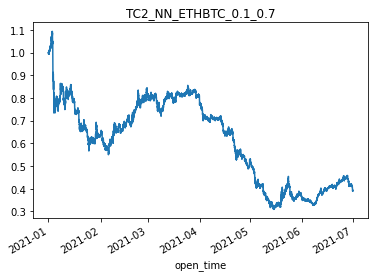

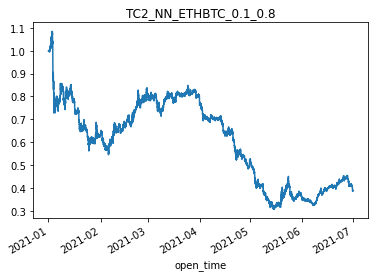

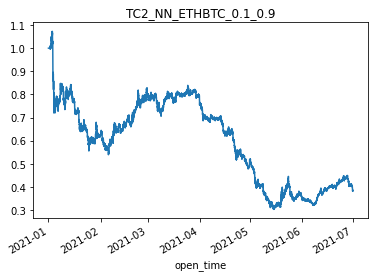

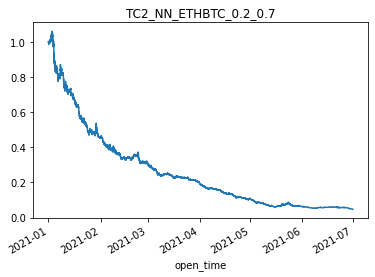

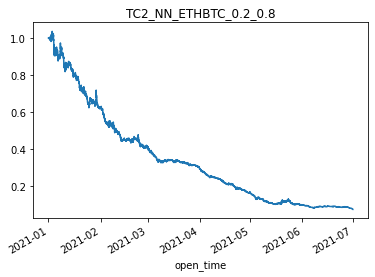

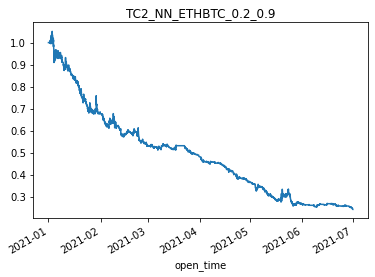

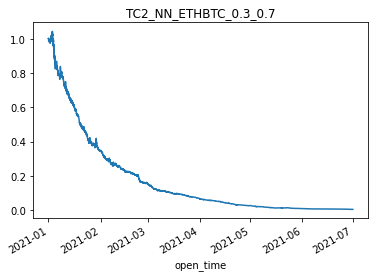

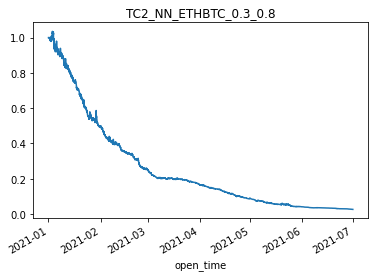

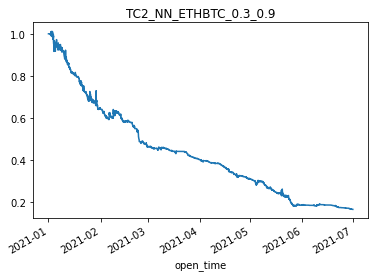

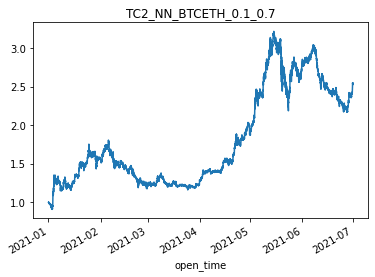

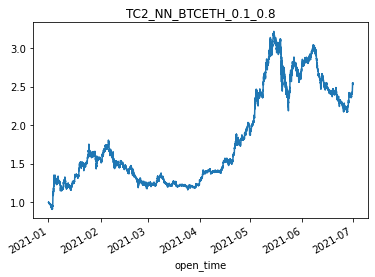

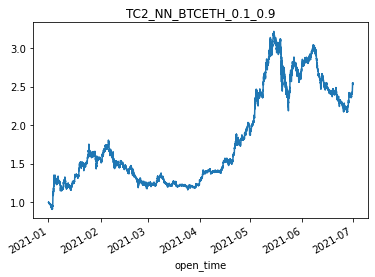

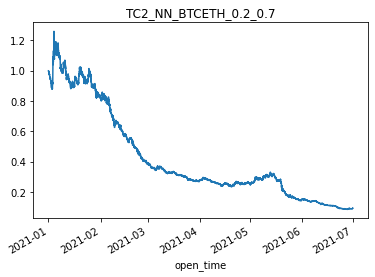

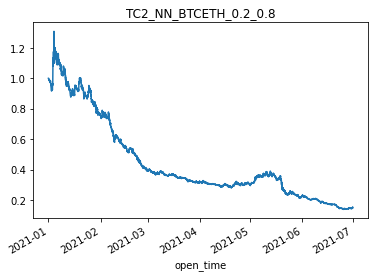

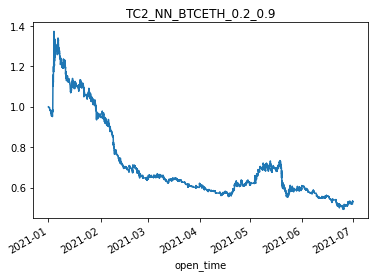

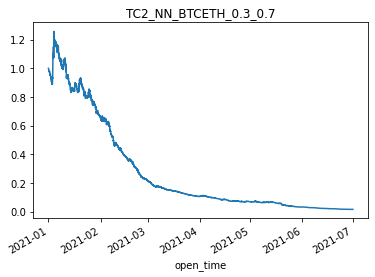

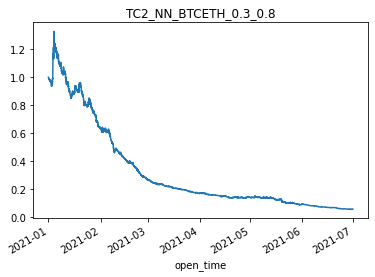

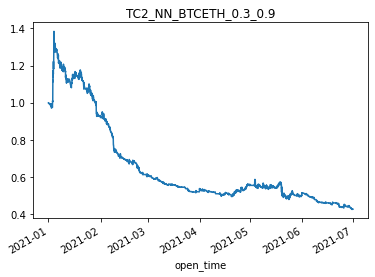

In [9]:
import matplotlib.pyplot as plt
for k,v in simulation_results.items():
    v[v['actual_action']!='none'].to_csv(f'./results/{k}.csv')
    fig, ax = plt.subplots()
    fig.patch.set_facecolor('white')
    ax.set_title(k)
    v.total_value.plot(figure=fig)

In [10]:
# Daily value
{k:v[v.index.hour + v.index.minute == 0]['total_value'] for k,v in simulation_results.items()}

{'TC2_NN_ETHBTC_0.1_0.7': open_time
 2021-01-01    1.000000
 2021-01-02    1.020605
 2021-01-03    1.052391
 2021-01-04    0.852943
 2021-01-05    0.754627
                 ...   
 2021-06-27    0.446472
 2021-06-28    0.443487
 2021-06-29    0.418707
 2021-06-30    0.421941
 2021-07-01    0.393153
 Name: total_value, Length: 182, dtype: float64,
 'TC2_NN_ETHBTC_0.1_0.8': open_time
 2021-01-01    1.000000
 2021-01-02    1.011794
 2021-01-03    1.043306
 2021-01-04    0.845579
 2021-01-05    0.748112
                 ...   
 2021-06-27    0.442617
 2021-06-28    0.439659
 2021-06-29    0.415092
 2021-06-30    0.418299
 2021-07-01    0.389759
 Name: total_value, Length: 182, dtype: float64,
 'TC2_NN_ETHBTC_0.1_0.9': open_time
 2021-01-01    1.000000
 2021-01-02    1.000448
 2021-01-03    1.031607
 2021-01-04    0.836098
 2021-01-05    0.739723
                 ...   
 2021-06-27    0.437654
 2021-06-28    0.434729
 2021-06-29    0.410437
 2021-06-30    0.413608
 2021-07-01    0.385388
 N

In [11]:
simulation_results['TC2_NN_EB_test']

KeyError: 'TC2_NN_EB_test'